<a href="https://colab.research.google.com/github/kikiru328/Bone_Detection/blob/main/Final_preprocessing_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import glob
import math

##### 0. read_img (read_img(path)

In [2]:
def read_img(path):
    original_img = cv2.imread(path)
    return original_img

##### 1. Make_mask (make_mask(original_img))

In [3]:
########## Making mask for removing background #############

def make_mask(original_img):

    ## change to lab for making mask

    img_mask = original_img.copy()

    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_RGB2BGR)
    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2Lab)
    
    ## blur _02 
    # kernel_size = odds / value = img.mean()


    blur_k = int((img_mask.mean()*0.5)//2)*2+1
    img_mask = cv2.medianBlur(img_mask, blur_k)
    
    ## change to Grayscale for threshold

    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_Lab2BGR)
    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)

    ## binary / value = img.mean()

    if img_mask.mean() > 100 : 
      th = img_mask.mean()*0.94
    else : 
      th = img_mask.mean()

    ret, img_mask = cv2.threshold(img_mask, th, 255, cv2.THRESH_BINARY)

    ## mask based Max value of contours

    contours, hierarchy = cv2.findContours(img_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img_mask.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)
    
    ## Applying for dilation

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (8,8))
    mask = cv2.dilate(mask,k)
    return mask

##### 2. cutting_mask (cut_mask(original_img, mask))

In [4]:
######## background cut based mask ##########

def cut_mask(original_img, mask):

    ## copying
    img_for_cut = original_img.copy()

    ## H/W
    height, width = img_for_cut.shape[:2]

    ## mask
    mask_list = mask.tolist()
    
    for y in range(int(height*0.05),height):
        if max(mask[y,int(width*0.3):int(width*0.7)]) > 0:
            start_y = y-int(height*0.05)
            break
            
    for x in range(int(width*0.05),width):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            start_x = x-int(width*0.05)
            break
            
    for x in range(int(width*0.95),-1,-1):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            end_x = x+int(width*0.05)
            break
            
    cut_index = 0
    if mask_list[height-1][-1] == 255 or mask_list[height-1][0] == 255:
        for n in reversed(range(height)):
            if mask_list[n][0] == 0 or mask_list[n][-1] == 0:
                cut_index = n
                break
                
    if cut_index == 0:
        cut_index = height

    ## converting color
    img_for_cut = cv2.cvtColor(img_for_cut, cv2.COLOR_BGR2GRAY) 

    img_for_cut = img_for_cut[start_y:(cut_index-1),start_x:end_x]
    mask = mask[start_y:(cut_index-1),start_x:end_x]

    ## remove background
    masked = cv2.bitwise_and(img_for_cut, mask)

    return masked

##### 3. Overlaying contours (overlay_contours(masked))

In [5]:
######## Overlaying ########

def overlay_contours(masked):
    copied_img = masked.copy()

    ## smoothing
    gray_smooth = cv2.bilateralFilter(copied_img, 7,60,60)

    ## contours
    outline = cv2.Canny(gray_smooth,50,50)

    ## overlay
    overlaied_img = cv2.add(masked,outline)
    return overlaied_img

##### 4. Rotation (img_rotation(overlaied_img))

In [6]:
######## Rotation ########

def img_rotation(overlaied_img):

    ## copying img
    before_rot_img = overlaied_img.copy()

    
    h, w = before_rot_img.shape[:2]
    before_rot_img = cv2.cvtColor(before_rot_img, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(before_rot_img, cv2.COLOR_BGR2GRAY)
    ret, th = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    th_li = th.tolist()

    ## Rotation stage 01
    # lower = first black spot

    for i in reversed(range(h)):
        if th_li[i][0] == 0 and th_li[i][-1] == 0:
            lower = i
            break

    # lower = condition ; bottom = lower / img * 0.95

    if lower == h - 1:
        lower = int(h*0.9)

    # upper = condition ; lower + lower * 0.05

    slice5 = int(len(th)*0.05)
    upper = lower - slice5

    # x, y = between upper and lower (5%) / wrist center

    x,y = [],[]
    for i in range(slice5):
        cnt = th_li[i + upper].count(255)
        index = th_li[i + upper].index(255)
        x.append([i+upper])
        y.append([int((index*2 + cnt - 1)/2)])

    # x, y / draw regression line

    model = LinearRegression()
    model.fit(X=x,y=y)

    ####################################################

    ## Rotation stage 02
    
    angle = math.atan2(h - 0, int(model.predict([[h]])) - int(model.predict([[0]])))*180/math.pi
    M = cv2.getRotationMatrix2D((w/2,h/2), angle-90, 1)
    rotate = cv2.warpAffine(before_rot_img, M, (w, h))

    # Cutting img (rotated img)

    for i in range(len(th[-1])):
        if th[-1][i] == 255:
            start_x = i
            break

    for i in range(len(th[-1])):
        if th[-1][i] == 255:
            end_x = i
            

    s_point = h - int((int(model.predict([[h]])-start_x)) * math.tan(math.pi*((90-angle)/180)))
    e_point = h - int((end_x - int(model.predict([[h]]))) * math.tan(math.pi*((angle-90)/180)))
    point = max(s_point, e_point)
    rotated_img = rotate[:point]
    return rotated_img

##### 5. Decomposing (Decomposing(rotated_img,a,b,d,e))

###### (1) contrast

In [7]:
######## Decompose_contrast ########
def contrast_roi(img, low, high):

    ## height, width

    h, w = img.shape
    img_ = np.zeros(img.shape, dtype=np.uint8)

    for y in range(h):
        for x in range(w):
            temp = int((255 / (high - low)) * (img[y][x] - low))
            if temp > 255:
                img_[y][x] = 255
            elif temp < 0:
                img_[y][x] = 0
            else:
                img_[y][x] = temp
    return img_

###### (2) brightness

In [8]:
######## Decompose_brightness ########
def bright_ness(img):
    ## columns, rows
    cols, rows = img.shape[:2]
    brightness = np.sum(img) / (255 * cols * rows)
    return brightness

In [13]:
######## Decomposing ########

### img, morphology_value_1, morphology_value_2, filter_value(a,b)

def Decomposing(rotated_img,a,b,d,e):

    ######## Decomposing_stage_1 / [ Contours , Mask ] ########
    decomp_img_1 = rotated_img.copy()

    ## Adjusting brighness

    if bright_ness(decomp_img_1) > 0.8:
        decomp_img_1 = np.clip(decomp_img_1 - 80., 0, 255).astype(np.uint8)
    elif bright_ness(decomp_img_1) > 0.75:
        decomp_img_1 = np.clip(decomp_img_1 - 50., 0, 255).astype(np.uint8)
    elif bright_ness(decomp_img_1) > 0.65:
        decomp_img_1 = np.clip(decomp_img_1 - 30., 0, 255).astype(np.uint8)
    else: decomp_img_1 = np.clip(decomp_img_1 - 10., 0, 255).astype(np.uint8)


    ## change to Lab

    decomp_img_1 = cv2.cvtColor(decomp_img_1, cv2.COLOR_RGB2BGR)
    decomp_img_1 = cv2.cvtColor(decomp_img_1, cv2.COLOR_BGR2Lab)

    ## Morphology

    k = cv2.getStructuringElement(cv2.MORPH_CROSS, (a, a))
    decomp_img_1 = cv2.morphologyEx(decomp_img_1, cv2.MORPH_TOPHAT, k) # Emphasis

    ## Filter

    decomp_img_1 = cv2.bilateralFilter(decomp_img_1,-1, d, e)

    ## Lab to gray for binary

    decomp_img_1 = cv2.cvtColor(decomp_img_1, cv2.COLOR_Lab2BGR)
    decomp_img_1 = cv2.cvtColor(decomp_img_1, cv2.COLOR_BGR2GRAY)

    ## img_normalization

    decomp_img_1 = cv2.normalize(decomp_img_1, None, 0, 255, cv2.NORM_MINMAX)

    ## CLAHE

    decomp_img_1 = cv2.equalizeHist(decomp_img_1)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(3,3)) 
    decomp_img_1= clahe.apply(decomp_img_1)          


    ## Threshold / value = img.mean()
    ret, mask = cv2.threshold(decomp_img_1,
                            np.mean(decomp_img_1),
                            255,
                            cv2.THRESH_BINARY) 

    ## Extract object / same value pixels

    contours, hierarchy = cv2.findContours(mask, 
                                            cv2.RETR_EXTERNAL, # only outline
                                            cv2.CHAIN_APPROX_SIMPLE) # Contour vertex coordinate


    ## drawing Contours

    cv2.drawContours(mask, contours, -1, (255,255,255), -1) # -1: 모든 컨트어 표시 /color/ fill


        
    ######## Decomposing_stage_2 / [ Brightness_Empahsis ] ########



    ## Empahsis
    decomp_img_2 = rotated_img.copy()
    if bright_ness(decomp_img_2) > 0.8:
        decomp_img_2 = np.clip(decomp_img_2 - 80., 0, 255).astype(np.uint8)
    elif bright_ness(decomp_img_2) > 0.75:
        decomp_img_2 = np.clip(decomp_img_2 - 50., 0, 255).astype(np.uint8)
    elif bright_ness(decomp_img_2) > 0.65:
        decomp_img_2 = np.clip(decomp_img_2 - 30., 0, 255).astype(np.uint8)
    else: decomp_img_2 = np.clip(decomp_img_2 - 10., 0, 255).astype(np.uint8)


    ## Morphology
    k2 = cv2.getStructuringElement(cv2.MORPH_CROSS,(b,b))
    decomp_img_2 = cv2.morphologyEx(decomp_img_2, cv2.MORPH_TOPHAT, k2)

    ## contrast
    decomp_img_2 = cv2.cvtColor(decomp_img_2, cv2.COLOR_BGR2RGB)
    decomp_img_2 = cv2.cvtColor(decomp_img_2, cv2.COLOR_BGR2GRAY)

    if decomp_img_2.mean() <= 15:
        low = decomp_img_2.mean() * 3.2
        high = decomp_img_2.mean() * 3.6
    elif decomp_img_2.mean() <= 20:
        low = decomp_img_2.mean() * 3
        high = decomp_img_2.mean() * 3.6
    else:
        low = decomp_img_2.mean() * 3
        high = decomp_img_2.mean() * 3.7

    decomp_img_2 = cv2.blur(decomp_img_2,(2,2))
    decomp_img_2 = contrast_roi(decomp_img_2, low, high)


    ######## Decomposing_Final_stage / [ Result ] ########

    ### Bone empahsis / bitwise (mask)

    ## Morphology

    ## Contours
    contours, hierarchy = cv2.findContours(decomp_img_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(decomp_img_2, contours, -1, (255, 255, 255), -1)

    ## Bitwise (mask) / print white parts

    decomp_img_2 = cv2.bitwise_and(decomp_img_2, mask) 

    decomp_img_2 = cv2.cvtColor(decomp_img_2, cv2.COLOR_GRAY2BGR)
    decomp_img_2 = cv2.blur(decomp_img_2,(2,2))

    bone_extraction = cv2.resize(decomp_img_2, (600, 800))

    return bone_extraction



##### Bone_extraction(path)

In [90]:
def Bone_extraction(path):
    try:
        original_img = read_img(path)
        mask = make_mask(original_img)
        masked = cut_mask(original_img, mask)
        overlaied_img = overlay_contours(masked)
        rotated_img = img_rotation(overlaied_img)
        bone = Decomposing(rotated_img,60,55,50,25)
        return bone

    except:
        print('ERROR > Please check again' ) 


 

In [92]:
a = '/content/drive/MyDrive/Bone_detection/data/image/female/1F.jpg'
b = '/content/drive/MyDrive/Bone_detection/data/image/female/1_F.jpg'

In [93]:
checkList = [a,b]

ERROR > Please check again


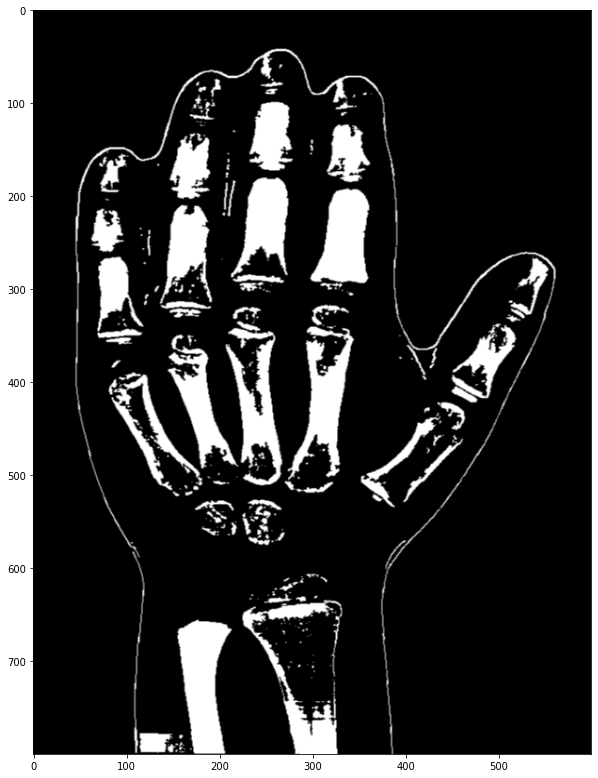

In [94]:
for i in checkList:
    bone = Bone_extraction(i)

plt.figure(figsize=(10,15))
plt.imshow(bone)

In [56]:
# import 

import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import glob
import math
# import image_dehazer